## 自己复现单层神经网络模型的时候重要的几个参数是：
### _n_input, n_output, n_epoch, batch_size_
### _net_
### _loss_
### _optimizer_

In [1]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt
import d2lzh_pytorch as d2l
import mypytorch
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
x = torch.rand(2, 3, 2)
x

tensor([[[0.3168, 0.7777],
         [0.8155, 0.8393],
         [0.5485, 0.6157]],

        [[0.6751, 0.3362],
         [0.8321, 0.8862],
         [0.2270, 0.4419]]])

In [3]:
x.argmax(dim=0)

tensor([[1, 0],
        [1, 1],
        [0, 0]])

In [4]:
x.argmax(dim=1)

tensor([[1, 1],
        [1, 1]])

In [5]:
x.argmax(dim=2)

tensor([[1, 1, 1],
        [0, 1, 1]])

In [6]:
x = torch.tensor([[1. ,2., 3.], [1., 2., 3.]], requires_grad=True)
y = torch.pow(x, 2)
y.backward(torch.ones_like(y))
x, y, x.grad

(tensor([[1., 2., 3.],
         [1., 2., 3.]], requires_grad=True),
 tensor([[1., 4., 9.],
         [1., 4., 9.]], grad_fn=<PowBackward0>),
 tensor([[2., 4., 6.],
         [2., 4., 6.]]))

In [7]:
def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

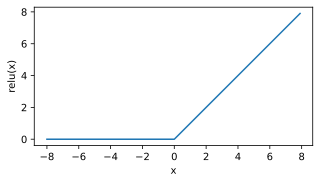

In [8]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

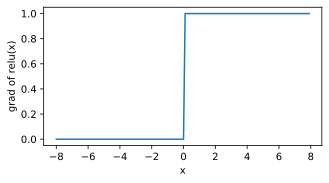

In [9]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

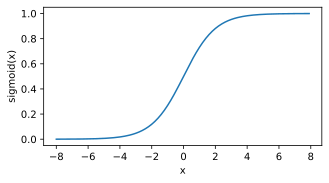

In [10]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

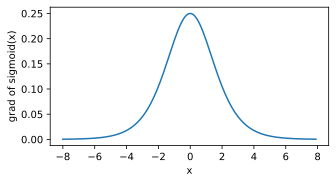

In [11]:
x.grad.zero_()#清除梯度
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

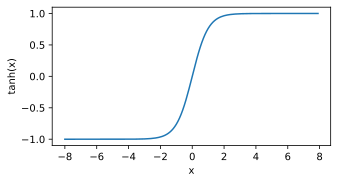

In [12]:
y = x.tanh()
xyplot(x, y, 'tanh')

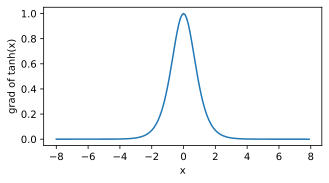

In [13]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

## 多项式拟合实验

In [14]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) # 张量按行拼接，其实就是3个输入
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b) # 标签y=1.2*x-3.4*x^2+5.6*x^3+5
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float) # 增加干扰量
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.2101],
         [ 2.2584]]),
 tensor([[-2.1011e-01,  4.4147e-02, -9.2758e-03],
         [ 2.2584e+00,  5.1004e+00,  1.1519e+01]]),
 tensor([ 4.5506, 54.8630]))

In [15]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)


def fit_and_plot(train_features, test_features, train_labels, test_labels):
    num_epochs, loss = 100, torch.nn.MSELoss()
    net = torch.nn.Linear(train_features.shape[-1], 1)  # 其实相当于初始化一个随机的W（100*1）和b
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])  # 小批量
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 其实就是把数据集丢到一个容器里
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # 相当于一个迭代器，每次抽取batch_size的数据

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)  # 优化器，这里是用梯度下降
    train_ls, test_ls = [], []  # 记录的损失
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))  # net算出来的是估计值，与y值计算做损失值
            optimizer.zero_grad()  # 梯度清零
            l.backward()  # 计算梯度
            optimizer.step()  # 优化器更新
        train_labels = train_labels.view(-1, 1)  # 训练的y
        test_labels = test_labels.view(-1, 1)  # 测试的y
        train_ls.append(loss(net(train_features), train_labels).item())  # 记录更新之后的net损失值
        test_ls.append(loss(net(test_features), test_labels).item())  # 记录更新之后的net损失值
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',  # 画图
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,  # 输出权重和偏置
          '\nbias:', net.bias.data)


##### 正常拟合

final epoch: train loss 0.00010039527114713565 test loss 0.00011320014164084569
weight: tensor([[ 1.1980, -3.4002,  5.6005]]) 
bias: tensor([4.9999])


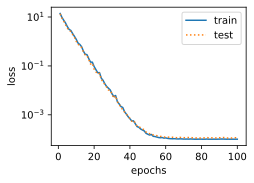

In [16]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

##### 欠拟合（非线性用线性模型训练）

final epoch: train loss 217.67117309570312 test loss 84.3075180053711
weight: tensor([[17.8589]]) 
bias: tensor([0.7803])


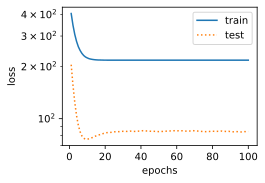

In [17]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

##### 过拟合（样本太小）

final epoch: train loss 1.0861502885818481 test loss 60.482566833496094
weight: tensor([[0.4411, 1.2377, 3.8553]]) 
bias: tensor([3.1506])


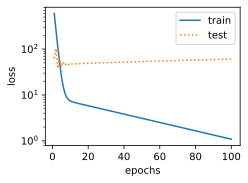

In [18]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

## 权重衰减
权重衰减等价于 L2范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段

## 高维线性回归实验

In [19]:
def l2_penalty(w):
    return (w**2).sum()/2

def init_params(num_inputs):
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def fit_and_plot2(train_features, test_features, train_labels, test_labels, lambd):
    batch_size, num_epochs, lr = 1, 100, 0.003
    net, loss = d2l.linreg, d2l.squared_loss

    w, b = init_params(train_features.shape[-1])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 其实就是把数据集丢到一个容器里
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # 相当于一个迭代器，每次抽取batch_size的数据
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()

            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_labels = train_labels.view(-1, 1)  # 训练的y
        test_labels = test_labels.view(-1, 1)  # 测试的y
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())  # 记录更新之后的net损失值
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())  # 记录更新之后的net损失值
    # print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',  # 画图
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight.norm:', w.norm().item())  # 输出权重L2范数
          # '\nbias:', b.item())

In [20]:
n_train, n_test, n_input = 20, 100, 200
true_w, true_b = torch.ones(n_input, 1) * 0.01, 0.05
features = torch.randn((n_train + n_test, n_input))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float) # 增加干扰量
train_features, test_features = features[:n_train], features[n_train:]
train_labels, test_labels = labels[:n_train], labels[n_train:]

#### 不使用权重衰减下的过拟合（因为这里刻意限制训练集大小）

weight.norm: 14.86878776550293


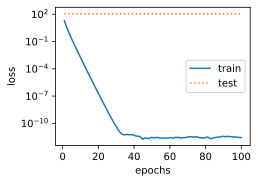

In [21]:
fit_and_plot2(train_features, test_features, train_labels, test_labels, 0)

#### 将lambd值逐渐调高，可见过拟合现象减弱，且权重的L2范数更加接近于0

weight.norm: 0.04942033812403679


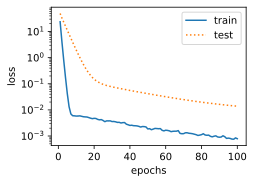

In [22]:
fit_and_plot2(train_features, test_features, train_labels, test_labels, 3)

weight.norm: 0.026803581044077873


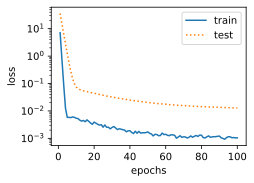

In [23]:
fit_and_plot2(train_features, test_features, train_labels, test_labels, 7)

### 用pytorch实现

In [24]:
def fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,wd):
    batch_size, num_epochs, lr = 1, 100, 0.003
    loss = torch.nn.MSELoss()
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = torch.nn.Linear(train_features.shape[-1], 1)
    torch.nn.init.normal_(net.weight, mean=0, std=1)
    torch.nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 其实就是把数据集丢到一个容器里
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # 相当于一个迭代器，每次抽取batch_size的数据
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()

            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())


L2 norm of w: 14.662248611450195


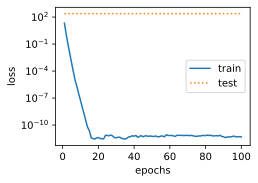

In [25]:
fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,0)

L2 norm of w: 0.05560589209198952


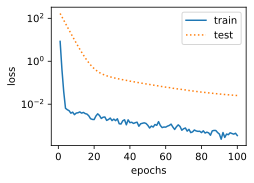

In [26]:
fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,3)

L2 norm of w: 0.03360975533723831


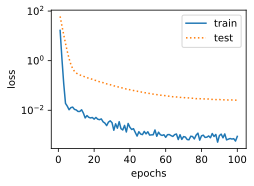

In [27]:
fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,7)

## Module 类

In [28]:
# 自己写的带两个隐藏层（hidden1 hidden2）和一个激活函数（act）的模型
class MLP(nn.Module):
    def __init__(self, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.hidden1 = nn.Linear(784, 256) # 其实就是一个带可变参数的矩阵 有w和b
        self.act = nn.ReLU()
        self.hidden2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, X):
        return self.output(self.hidden2(self.act(self.hidden1(X))))

In [29]:
net = MLP()
x = torch.randn((10, 784))
net ,net(x)

(MLP(
   (hidden1): Linear(in_features=784, out_features=256, bias=True)
   (act): ReLU()
   (hidden2): Linear(in_features=256, out_features=128, bias=True)
   (output): Linear(in_features=128, out_features=10, bias=True)
 ),
 tensor([[-4.6789e-02, -1.6095e-01,  1.7445e-02,  3.9933e-02,  1.4301e-01,
           6.5793e-02, -2.1667e-01, -4.9429e-02,  1.6533e-01,  1.9632e-01],
         [-9.6678e-02, -1.6662e-01, -4.6427e-02,  1.1875e-01, -8.0431e-02,
           8.0530e-02, -1.0843e-01,  2.3203e-01,  1.5259e-01, -2.4824e-03],
         [-1.4987e-01,  3.9773e-02, -6.9580e-02, -1.2198e-01, -9.2258e-02,
           1.2660e-02,  2.0829e-02, -3.8399e-02,  8.7642e-02,  1.6408e-01],
         [-5.9680e-04, -1.3724e-01, -4.9465e-03,  2.1345e-01, -3.6869e-02,
          -1.1297e-01,  8.6004e-02, -1.2143e-02,  1.2907e-01,  1.5943e-01],
         [-9.5801e-02, -6.1615e-04, -1.1620e-02,  1.3264e-01, -5.7325e-02,
           1.7072e-01,  5.7774e-02,  1.8767e-01,  8.1835e-02, -2.2349e-02],
         [-1.5209e-

## 卷积

In [30]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 1], [2, 3]])
mypytorch.corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [31]:
from mypytorch import corr2d
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

#### 边缘滤波

In [32]:
X = torch.ones(6, 8)
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [33]:
K = torch.tensor([[-1, 1]])
Y = corr2d(X, K)
Y

tensor([[ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.]])

#### 用卷积层来求出边缘滤波

step 5 loss: 9.049
step 10 loss: 1.409
step 15 loss: 0.269
step 20 loss: 0.061
weight: tensor([[-0.9286,  0.9559]])
bias: tensor([-0.0153])


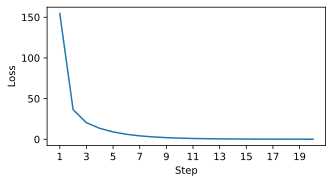

In [34]:
from mypytorch import loss_plot
conv2d = Conv2D(kernel_size=(1, 2))

step = 20
lr = 0.01
l_list = []
for i in range(step):
    Y_hat = conv2d(X)
    l = ((Y - Y_hat)**2).sum()
    l_list.append(l.data)

    l.backward()

    conv2d.weight.data -= lr * conv2d.weight.grad  # 这边权重用data的原因是不希望这边的变化计入grad中
    conv2d.bias.data -= lr * conv2d.bias.grad

    conv2d.weight.grad.fill_(0)
    conv2d.bias.grad.fill_(0)

    if (i+1) % 5 == 0:
        print('step {} loss: {:.3f}'.format(i+1, l.item()))

print(f'weight: {conv2d.weight.data}\nbias: {conv2d.bias.data}')
loss_plot(list(range(1, 21)), l_list, x_limit=2)


#### 多输入卷积

In [35]:
X = torch.tensor([[[1, 2, 3], [4, 5, 6], [7, 8, 9]],
                [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[1, 2], [3, 4]],
                  [[1, 2], [3, 4]]])
K.shape, mypytorch.corr2d_multi_in(X, K)

(torch.Size([2, 2, 2]),
 tensor([[ 74.,  94.],
         [134., 154.]]))

#### 多输入输出卷积

In [36]:
K = torch.stack([K, K, K-1, K+1])
out = mypytorch.corr2d_multi_in_out(X, K)
K.shape, out.shape

(torch.Size([4, 2, 2, 2]), torch.Size([4, 2, 2]))

#### 1x1卷积核，虽然看起来没用，但其实是变换通道数

In [37]:
K = torch.tensor([[[1]],
                  [[2]]])
K = torch.stack([K, K+1, K+2])
mypytorch.corr2d_multi_in_out_1x1(X, K), mypytorch.corr2d_multi_in_out(X, K)

(tensor([[[ 3,  6,  9],
          [12, 15, 18],
          [21, 24, 27]],
 
         [[ 5, 10, 15],
          [20, 25, 30],
          [35, 40, 45]],
 
         [[ 7, 14, 21],
          [28, 35, 42],
          [49, 56, 63]]]),
 tensor([[[ 3.,  6.,  9.],
          [12., 15., 18.],
          [21., 24., 27.]],
 
         [[ 5., 10., 15.],
          [20., 25., 30.],
          [35., 40., 45.]],
 
         [[ 7., 14., 21.],
          [28., 35., 42.],
          [49., 56., 63.]]]))

#### 卷积填充与步幅
也许有细心的同学已经发现了，emm…卷积层最重要的可学习参数——权重参数和偏置参数去哪了？在Tensorflow中都是先定义好weight和bias，再去定义卷积层的呀！别担心，在Pytorch的nn模块中，它是不需要你手动定义网络层的权重和偏置的，这也是体现Pytorch使用简便的地方。当然，如果有小伙伴适应不了这种不定义权重和偏置的方法，Pytorch还提供了nn.Functional函数式编程的方法，其中的F.conv2d()就和Tensorflow一样，要先定义好卷积核的权重和偏置，作为F.conv2d（）的形参之一。
  回到nn.Conv2d上来，我们可以通过实例名.weight和实例名.bias来查看卷积层的权重和偏置，如上图所示。还有小伙伴要问了，那么它们是如何初始化的呢？
  首先给结论，在nn模块中，Pytorch对于卷积层的权重和偏置（如果需要偏置）初始化都是采用He初始化的，因为它非常适合于ReLU函数。这一点大家看Pytorch的nn模块中卷积层的源码实现就能清楚地发现了，当然，我们也可以重新对权重等参数进行其他的初始化，可以查看其他教程，此处不再多言。

in_channels
  这个很好理解，就是输入的四维张量[N, C, H, W]中的C了，即输入张量的channels数。这个形参是确定权重等可学习参数的shape所必需的。

out_channels
  也很好理解，即期望的四维输出张量的channels数，不再多说。

kernel_size
  卷积核的大小，一般我们会使用5x5、3x3这种左右两个数相同的卷积核，因此这种情况只需要写kernel_size = 5这样的就行了。如果左右两个数不同，比如3x5的卷积核，那么写作kernel_size = (3, 5)，注意需要写一个tuple，而不能写一个列表（list）。

stride = 1
  卷积核在图像窗口上每次平移的间隔，即所谓的步长。这个概念和Tensorflow等其他框架没什么区别，不再多言。

padding = 0
  Pytorch与Tensorflow在卷积层实现上最大的差别就在于padding上。
  Padding即所谓的图像填充，后面的int型常数代表填充的多少（行数、列数），默认为0。需要注意的是这里的填充包括图像的上下左右，以padding = 1为例，若原始图像大小为32x32，那么padding后的图像大小就变成了34x34，而不是33x33。
  Pytorch不同于Tensorflow的地方在于，Tensorflow提供的是padding的模式，比如same、valid，且不同模式对应了不同的输出图像尺寸计算公式。而Pytorch则需要手动输入padding的数量，当然，Pytorch这种实现好处就在于输出图像尺寸计算公式是唯一的，即

  当然，上面的公式过于复杂难以记忆。大多数情况下的kernel_size、padding左右两数均相同，且不采用空洞卷积（dilation默认为1），因此只需要记 O = （I - K + 2P）/ S +1这种在深度学习课程里学过的公式就好了。

dilation = 1
  这个参数决定了是否采用空洞卷积，默认为1（不采用）。从中文上来讲，这个参数的意义从卷积核上的一个参数到另一个参数需要走过的距离，那当然默认是1了，毕竟不可能两个不同的参数占同一个地方吧（为0）。
  更形象和直观的图示可以观察Github上的Dilated convolution animations，展示了dilation=2的情况。

groups = 1
  决定了是否采用分组卷积，groups参数可以参考groups参数详解

bias = True
  即是否要添加偏置参数作为可学习参数的一个，默认为True。

padding_mode = ‘zeros’
  即padding的模式，默认采用零填充。

In [38]:
def part_of_conv2d(conv2d, X):
    X = X.view((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.view(Y.shape[2:])

conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=(1, 2))  ## padding 填充， stride 步幅
X = torch.randn((8, 8))
part_of_conv2d(conv2d, X).shape

torch.Size([8, 4])

#### 池化层
在本节中我们介绍池化（pooling）层，它的提出是为了缓解卷积层对位置的过度敏感性

In [39]:
X = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
mypytorch.pool2d(X, (2, 2), mode='max'), mypytorch.pool2d(X, (2, 2), mode='avg')

(tensor([[5., 6.],
         [8., 9.]]),
 tensor([[3., 4.],
         [6., 7.]]))

#### 池化层的填充和步幅

In [40]:
X = torch.arange(16, dtype=torch.float).view(1, 1, 4, 4)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [41]:
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
pool2d(X)

tensor([[[[ 5.,  6.,  7.,  7.],
          [ 9., 10., 11., 11.],
          [13., 14., 15., 15.],
          [13., 14., 15., 15.]]]])

In [42]:
pool2d = nn.MaxPool2d(kernel_size=3, padding=0, stride=1)
pool2d(X)

tensor([[[[10., 11.],
          [14., 15.]]]])

In [43]:
pool2d = nn.MaxPool2d(kernel_size=(2, 3), padding=1, stride=(1, 2))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 5.,  7.],
          [ 9., 11.],
          [13., 15.],
          [13., 15.]]]])

In [44]:
X_1 = torch.cat((X, X+1), dim=1) # 四维：样本数、通道数、长、宽
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
pool2d(X_1)

tensor([[[[ 5.,  6.,  7.,  7.],
          [ 9., 10., 11., 11.],
          [13., 14., 15., 15.],
          [13., 14., 15., 15.]],

         [[ 6.,  7.,  8.,  8.],
          [10., 11., 12., 12.],
          [14., 15., 16., 16.],
          [14., 15., 16., 16.]]]])

## 卷积神经网络识别手写数字

In [45]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [46]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Linear(120, 84),
            nn.Linear(84, 10)
        )
    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [47]:
net = LeNet()
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [48]:
from torchvision.transforms import transforms
import torchvision

batch_size = 256
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, mnist_train, mnist_test)

In [49]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
l_list = mypytorch.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on cpu
epoch 1, loss 1.3592, train acc 0.488, test acc 0.688, time 12.8 sec
epoch 2, loss 0.7276, train acc 0.722, test acc 0.731, time 13.1 sec
epoch 3, loss 0.6618, train acc 0.743, test acc 0.731, time 14.7 sec
epoch 4, loss 0.6161, train acc 0.762, test acc 0.767, time 13.2 sec
epoch 5, loss 0.5771, train acc 0.777, test acc 0.765, time 12.4 sec


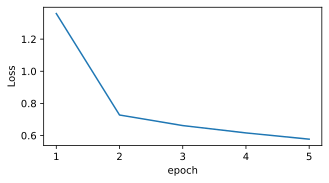

In [50]:
x_list = range(1, num_epochs + 1)
mypytorch.loss_plot(x_list, l_list, x_label='epoch')

## 深度卷积神经网络 Alexnet

In [51]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [52]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

In [53]:
batch_size = 128
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = mypytorch.load_data_fashion_mnist(batch_size, resize=224)

训练样本集容量: 60000 测试样本集容量: 10000


In [54]:
lr, num_epochs = 0.001, 1
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
l_list = mypytorch.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on cpu
epoch 1, loss 0.6325, train acc 0.757, test acc 0.850, time 1300.0 sec


-- --

## VGG

In [1]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt
import d2lzh_pytorch as d2l
import mypytorch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def vgg_block(num_convs, in_channels, out_channels):
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        else:
            blk.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 这里会使宽高减半
    return nn.Sequential(*blk)

In [3]:
net = vgg_block(3, 1, 255)
print(net)

Sequential(
  (0): Conv2d(1, 255, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(255, 255, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(255, 255, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [4]:
conv_arch = ((1, 1, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512))
# 经过5个vgg_block, 宽高会减半5次, 变成 224/32 = 7
fc_features = 512 * 7 * 7 # c * w * h
fc_hidden_units = 4096 # 任意

In [5]:
def vgg(conv_arch, fc_features, fc_hidden_units=4096):
    net = nn.Sequential()
    # 卷积层部分
    for i, (num_convs, in_channels, out_channels) in enumerate(conv_arch):
        # 每经过一个vgg_block都会使宽高减半
        net.add_module("vgg_block_" + str(i+1), vgg_block(num_convs, in_channels, out_channels))
    # 全连接层部分
    net.add_module("fc", nn.Sequential(d2l.FlattenLayer(),
                                 nn.Linear(fc_features, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, 10)
                                ))
    return net

In [6]:
net = vgg(conv_arch, fc_features, fc_hidden_units)
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [7]:
X = torch.randn((255, 1, 224, 224), dtype=torch.float)
for name, blk in net.named_children():
    X = blk(X)
    print(name, 'output shape: ', X.shape)

vgg_block_1 output shape:  torch.Size([255, 64, 112, 112])
vgg_block_2 output shape:  torch.Size([255, 128, 56, 56])
vgg_block_3 output shape:  torch.Size([255, 256, 28, 28])
vgg_block_4 output shape:  torch.Size([255, 512, 14, 14])
vgg_block_5 output shape:  torch.Size([255, 512, 7, 7])
fc output shape:  torch.Size([255, 10])


In [8]:
conv_arch = ((1, 1, 2), (1, 2, 4), (2, 4, 8), (2, 8, 16), (2, 16, 32))
# 经过5个vgg_block, 宽高会减半5次, 变成 224/32 = 7
fc_features = 32 * 7 * 7 # c * w * h
fc_hidden_units = 512 # 任意

In [9]:
net = vgg(conv_arch, fc_features, fc_hidden_units)
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [10]:
batch_size = 128
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = mypytorch.load_data_fashion_mnist(batch_size, resize=224)

训练样本集容量: 60000 测试样本集容量: 10000


In [11]:
X = torch.randn((255, 1, 224, 224), dtype=torch.float)
for name, blk in net.named_children():
    X = blk(X)
    print(name, 'output shape: ', X.shape)

vgg_block_1 output shape:  torch.Size([255, 2, 112, 112])
vgg_block_2 output shape:  torch.Size([255, 4, 56, 56])
vgg_block_3 output shape:  torch.Size([255, 8, 28, 28])
vgg_block_4 output shape:  torch.Size([255, 16, 14, 14])
vgg_block_5 output shape:  torch.Size([255, 32, 7, 7])
fc output shape:  torch.Size([255, 10])


In [13]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
l_list = mypytorch.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on cpu

epoch 1, loss 0.3713, train acc 0.864, test acc 0.872, time 257.4 sec

epoch 2, loss 0.3199, train acc 0.883, test acc 0.884, time 255.6 sec

epoch 3, loss 0.2924, train acc 0.892, test acc 0.889, time 250.2 sec

epoch 4, loss 0.2683, train acc 0.901, test acc 0.901, time 237.7 sec

epoch 5, loss 0.2507, train acc 0.909, test acc 0.899, time 222.7 sec


-- --

## NiN

In [2]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt
import d2lzh_pytorch as d2l
import mypytorch

In [3]:
def nin_block(in_channels, out_channels, kernel_size, stride, padding):
    blk = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU())
    return blk

In [4]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    mypytorch.GlobalAvgPool2d(),
    # 将四维的输出转成二维的输出，其形状为(批量大小, 10)
    d2l.FlattenLayer()
)
print(net)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (5): MaxPool2d(kernel_size=3, stri

In [6]:
X = torch.rand(1, 1, 224, 224)
for name, blk in net.named_children():
    X = blk(X)
    print(name, 'output shape: ', X.shape)

0 output shape:  torch.Size([1, 96, 54, 54])
1 output shape:  torch.Size([1, 96, 26, 26])
2 output shape:  torch.Size([1, 256, 26, 26])
3 output shape:  torch.Size([1, 256, 12, 12])
4 output shape:  torch.Size([1, 384, 12, 12])
5 output shape:  torch.Size([1, 384, 5, 5])
6 output shape:  torch.Size([1, 384, 5, 5])
7 output shape:  torch.Size([1, 10, 5, 5])
8 output shape:  torch.Size([1, 10, 1, 1])
9 output shape:  torch.Size([1, 10])


In [15]:
X = torch.tensor([[[[1, 2], [3, 4]], [[2, 3], [4, 5]]], [[[3, 4], [5, 6]], [[4, 5], [6, 7]]]], dtype=torch.float)
print(X)
mean = X.mean(dim=0, keepdim=True)
print(mean)
mean = X.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True)
print(mean)
mean = X.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
print(mean)

tensor([[[[1., 2.],
          [3., 4.]],

         [[2., 3.],
          [4., 5.]]],


        [[[3., 4.],
          [5., 6.]],

         [[4., 5.],
          [6., 7.]]]])
tensor([[[[2., 3.],
          [4., 5.]],

         [[3., 4.],
          [5., 6.]]]])
tensor([[[[3., 4.]],

         [[4., 5.]]]])
tensor([[[[3.5000]],

         [[4.5000]]]])


## BN批量归一化

In [16]:
def batch_norm(is_training, X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 判断当前模式是训练模式还是预测模式
    if not is_training:
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。这里我们需要保持
            # X的形状以便后面可以做广播运算
            mean = X.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 拉伸和偏移
    return Y, moving_mean, moving_var

In [24]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super(BatchNorm, self).__init__()
        # 首先要知道是全连接层还是卷积层
        if num_dims == 2:
            shape = (1, num_features)
        elif num_dims == 4:
            shape = (1, num_features, 1, 1)

        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成0和1
        self.gamma = nn.Parameter(torch.ones(shape))  # 使用nn.Parameter会自动加入该层的参数中，参与求梯度
        self.beta = nn.Parameter(torch.zeros(shape))  # 这里用到的是广播机制
        # 不参与求梯度和迭代的变量，全在内存上初始化成0
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var, Module实例的traning属性默认为true, 调用.eval()后设成false
        Y, self.moving_mean, self.moving_var = batch_norm(self.training,
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y


In [33]:
net = BatchNorm(100, 4)
for name, parameter in net.named_parameters():
    print(name, parameter.shape)

gamma torch.Size([1, 100, 1, 1])
beta torch.Size([1, 100, 1, 1])


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            BatchNorm(6, num_dims=4),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            BatchNorm(16, num_dims=4),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            d2l.FlattenLayer(),
            nn.Linear(16*4*4, 120),
            BatchNorm(120, num_dims=2),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            BatchNorm(84, num_dims=2),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

In [38]:
batch_size = 256
train_iter, test_iter = mypytorch.load_data_fashion_mnist(batch_size=batch_size)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
mypytorch.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

训练样本集容量: 60000 测试样本集容量: 10000
training on cpu
epoch 1, loss 1.0054, train acc 0.787, test acc 0.808, time 15.9 sec
epoch 2, loss 0.4627, train acc 0.862, test acc 0.819, time 14.4 sec
epoch 3, loss 0.3689, train acc 0.878, test acc 0.802, time 14.2 sec
epoch 4, loss 0.3307, train acc 0.887, test acc 0.848, time 13.9 sec
epoch 5, loss 0.3090, train acc 0.892, test acc 0.807, time 13.9 sec


[1.0053723520420967,
 0.46273986405514655,
 0.36885760058747963,
 0.3306820125655925,
 0.30900937724620736]

In [41]:
net[1].gamma.view((-1,)), net[1].beta.view((-1,))

(tensor([1.1054, 1.0452, 1.0721, 0.9470, 1.1157, 1.1806],
        grad_fn=<ViewBackward0>),
 tensor([ 0.2615, -0.3247, -0.6514,  0.3120,  0.4704, -0.1435],
        grad_fn=<ViewBackward0>))

In [44]:
net = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.BatchNorm2d(6),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            d2l.FlattenLayer(),
            nn.Linear(16*4*4, 120),
            nn.BatchNorm1d(120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
print(net)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Sigmoid()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): FlattenLayer()
  (9): Linear(in_features=256, out_features=120, bias=True)
  (10): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Sigmoid()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Sigmoid()
  (15): Linear(in_features=84, out_features=10, bias=True)
)


In [45]:
batch_size = 256
train_iter, test_iter = mypytorch.load_data_fashion_mnist(batch_size=batch_size)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
mypytorch.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

训练样本集容量: 60000 测试样本集容量: 10000
training on cpu
epoch 1, loss 0.9857, train acc 0.790, test acc 0.815, time 9.9 sec
epoch 2, loss 0.4562, train acc 0.863, test acc 0.763, time 10.3 sec
epoch 3, loss 0.3661, train acc 0.879, test acc 0.843, time 9.5 sec
epoch 4, loss 0.3309, train acc 0.886, test acc 0.854, time 9.6 sec
epoch 5, loss 0.3085, train acc 0.892, test acc 0.877, time 10.0 sec


[0.9856766122452756,
 0.45617678850255117,
 0.36611686646938324,
 0.3309341377400337,
 0.30847947743344817]

-- --